# Overfitting

... Normally? A bad thing! But for our case it's good...

We use a new method to mix an overfitted model (our own) with a pretrained model (GPT-Neo-125M) and have them share eachothers traits. This way it's possible to finetune a model without having to retrain it. It's so fast it can be done in a second on CPU.

In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import content_aware_encode, train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, visualize_lr
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 970988852
#seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 970988852


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [5]:
config = {
    'lr': 1e-4,
    "warmup_factor": 5,
    'scheduler': 'cycles_buildoff',
    "cycles": 100,
    "lr_end": 1e-6,
    "power": 0.6,
    #"freeze_from_steps": -1,
    'freeze_once': True,
    'freeze_layer_rate': 1e-4 * 0.05,
    'to_freeze_count': 150,
    "seed": seed,
    "num_epoch": 1000
}

# Show me your LR!

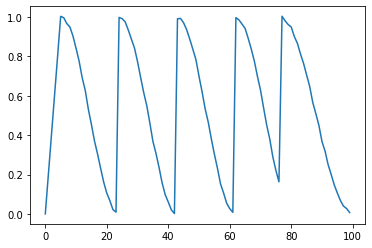

In [6]:
visualize_lr(config)

In [7]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained(Config.base_model_name)
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model(Config.base_model_name)
    print("Loaded empty model")
model = model.to(device)
print(f"{Config.base_model_name} loaded with {len(list(model.named_parameters()))} params...")
# set_pretrained_model_dropout(model.transformer.h, 0.0005)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Loaded empty model
EleutherAI/gpt-neo-125M loaded with 160 params...


# Test before training on a pretrained model!

In [8]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon and a dragon is a creature that can fly with my wings, and I'm also a dragon. When I'm in the city of Arken, I'm a dragon. But if I'm in the city of Arken, I don't know where I'm going. I don't know what's happening to me, and I don't know how I'm going to get out of this place. So, I'm a dragon. And I have a dragon. I have a dragon.

When I was in Arken, I'd been on the city of Arken for a couple


# Reviewing our dataset!

In [9]:
dataset = get_dataset(seed, tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
with open("data_train_sample.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
with open("data_train_sample2.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
print("RP review!")
to_see_rp = [
    'c "Fight',
    'c "What do you think of Lorem?'
]
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    for rp in list(to_see_rp):
        if rp in decoded: 
            print(decoded)
            print("-" * 10)
            to_see_rp.remove(rp)
            continue
    if len(to_see_rp) == 0:
        break
# Clean up
del to_see_rp

100%|██████████| 2/2 [00:00<00:00, 196.47it/s]


RP review!
 do, and rightfully so."<p><msg>c "What do you think of Lorem?"<d><scn>black<msg>Zh normal "I think he is good looking."<|endoftext|><d><scn>eckswimmingpool<msg>Nm smile "To miracles in our everyday lives, then."<d><scn>eckswimmingpool<msg>m "I took another long sip of my drink, mindful to keep enough of it at least for one final round."<d><scn>eckswimmingpool<msg>N
----------
><scn>eckwatersky01<msg>Nm stern "Not a chance."<p><msg>c "Let's see what inside that facility, then."<d><scn>eckwatersky01<msg>Nm smile "I'm with you."<d><scn>eckwatersky01<msg>m "I put my rebreather back on and went to the cave entrance at the seafloor."<p><msg>c "Fight"<d><scn>eckwatersky01<msg>m "Na
----------


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [10]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

train -> logging_steps: 920
[0] set freeze_part_layers: False (freezing 152 out of 160 layers.)


Step,Training Loss
100,3.208800
200,2.855900
300,2.652900
400,2.451500
500,2.306100
600,2.196200
700,2.162200
800,2.104600
900,2.086400
1000,2.068400


[24] set freeze_part_layers: True (freezing 152 out of 160 layers.)


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.w

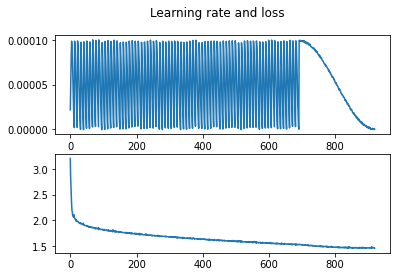

In [11]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

In [12]:
model.eval()
model.save_pretrained(saved_model_path)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


# RP evaluation

In [13]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight",
    "Bite",
    "Attack",
    "Go to store"
]

for rp in test_rps:
    start_prompt = '<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry happy "Hello, [player_name]."'
    print(f'{rp} -> {model_manager.say(start_prompt, rp)}')
    print(f'[sampled] {rp} -> {model_manager.say(start_prompt, rp, top_k = 50, top_p = 0.7)}')
    print("-" * 10)
    
print("Lowercase test")

for rp in test_rps:
    rp = rp[0].lower() + rp[1:]
    print(f'{rp} -> {model_manager.say("", rp)}')
    rp = rp.lower()
    print(f'{rp} -> {model_manager.say("", rp)}')
    print("-" * 10)

Visit Lorem -> park2<msg>Ry normal "Hey [player_name]!"<|endoftext|>
[sampled] Visit Lorem -> park2<msg>Ry smile "Hey [player_name]! How are you?"<|endoftext|>
----------
Meet with Lorem -> park2<msg>Mv normal "Hey [player_name]!"<|endoftext|>
[sampled] Meet with Lorem -> park2<msg>Mv nice "Hey [player_name]!"<|endoftext|>
----------
Visit Adine -> park2<msg>Ry normal "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
[sampled] Visit Adine -> park2<msg>Ry shy "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
----------
Fight -> park2<msg>m "Remy barely avoids my attack and fell, but managed to get up and quickly punch me in the face, a soaring pain quickly came over my face"<|endoftext|>
[sampled] Fight -> park2<msg>m "Remy only has one foot on his chest, and he had a few cuts in his body that should have made him less than average. Remy's wounds were as large as mine and had a large nose and an expression of fear and anger on its two edge

In [14]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry happy "Hello, [player_name]."', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad normal "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
    ('<p><msg>Nm "Ah, nice. I like it here."', "Can you swim?"),
]

def prompt_test(model_manager, do_sample_test = True):
    for (past, prompt) in prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(past, prompt)
        print(f"Reply: {reply}")
        if do_sample_test:
            reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
            print(f"Reply [sampled]: {reply}")
        print("-" * 10)
        
prompt_test(model_manager)

Prompt: How are you?
Reply: park2<msg>Ry shy "I'm just fine."<|endoftext|>
Reply [sampled]: park2<msg>Ry shy "You must be."<|endoftext|>
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>m "I could tell by the expression on his face."<p><msg>c "I think he's ugly."<|endoftext|>
Reply [sampled]: park2<msg>Ka normal "He is a bit interesting."<|endoftext|>
----------
Prompt: Oh my god, Adine. What is this?
Reply: park2<msg>Ry shy "I was with Katsuharu today"<d><scn>park2<msg>Ry shy "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
Reply [sampled]: black<msg>Ry shy "Hey [player_name]!"<|endoftext|>
----------
Prompt: What will we do here?
Reply: np1n<msg>An cry "I'll be sure to give up when I know I have to do something like that again."<p><msg>c "I'll do it."<d><scn>np1n<msg>m "I took a seat at the table and waited for the others to finish their work. After a few minutes, I noticed that Anna was still standing, still holding
Reply [sampled]: black<msg>